In [2868]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon, Circle
from matplotlib.collections import PatchCollection
from shapely.geometry import Point as ShapelyPoint
from shapely.geometry.polygon import Polygon as ShapelyPolygon

In [2869]:
#defines the value to use for max() to get third entity
def get_mult(ent):
    return ent[2]
#defines the value to use for max() to get second entity
def get_y(ent):
    return ent[1]
#defines the value to use for max() to get first entity
def get_x(ent):
    return ent[0]
def get_best_score(ent):
    return ent[0]
def get_best_index(ent):
    return ent[1]

In [2870]:
#empty until populated by algorithm
drone_list = []

In [2871]:
#decimal or 1 for 100%
min_coverage = 1

In [2872]:
#calculate height of drone and coverage radius
#parameters
wavelength = 0.125
directivity_transmitter_dBi = 14
directivity_reciever_dBi = 5
power_transmitter_dBm = -10
power_reciever_dBm = -70
aperature_angle = 60

#convert angle in degrees to radians
theta = aperature_angle*(np.pi/180)

#calculations
height = wavelength / (4 * np.pi * 10**((power_reciever_dBm - 
                                         (power_transmitter_dBm + directivity_transmitter_dBi + 
                                          directivity_reciever_dBi))/20))
coverage_radius = height * np.tan(theta)

print("Height: " + str(height))
print("Coverage Radius: " + str(coverage_radius))

#just for examples
coverage_radius = 10

Height: 88.65437021204667
Coverage Radius: 153.5538735202856


In [2873]:
#should be calculated from another function - yet to be created
#number of drones in each member of the population (each map)
num_drones = 4

In [2874]:
#population size
pop_size = 500

In [2875]:
#mutation rate
mutation_rate = 0.01

In [2876]:
#holds best fitness info
    #includes fitness score and index in population
best_fitness = (0, -1)

In [2877]:
#list of vertices in the polygon (in order of drawing)
map_vertex_list = np.array([(0,0), (40, 40), (60, 80), (100,100),(100,0)])
xmin = get_x(min(map_vertex_list, key=get_x))
xmax = get_x(max(map_vertex_list, key=get_x))
ymin = get_y(min(map_vertex_list, key=get_y))
ymax = get_y(max(map_vertex_list, key=get_y))

In [2878]:
#list of "hot spots" 
#format: (x coordinate, y coordinate, multiplicity - number of users at that location)
map_density_list = np.array([(10,10,5), (15,15,1), (70, 70, 10), (69, 8, 15), (75, 10, 5), (5, 5, 5), (100, 40, 10)])
tot_users = 0
for (_,_,u) in map_density_list:
    tot_users += u

In [2879]:
#fitness to strive for
optimal_fitness = tot_users*min_coverage
print("Optimal fitness: " + str(optimal_fitness))

Optimal fitness: 51


In [2880]:
map_poly = Polygon(map_vertex_list, True)
shapely_poly = ShapelyPolygon(map_vertex_list)

In [2881]:
#checks if a point is within the map polygon
def polygon_contains_point(point):
    point_to_check = ShapelyPoint(get_x(point), get_y(point))
    return shapely_poly.contains(point_to_check)

In [2882]:
#draws appropriate map - make more flexible with different polygons, make 

def draw_map(map_vertex_list, map_density_list, drone_list):
    
    patches = [map_poly]
    
    max_mult = get_mult(max(map_density_list, key=get_mult))
    #the following only runs after the computation has taken place and the drone positions have been calculated
    #handle drone selection circles
    for coord in drone_list:

        temp_circle = Circle(coord, radius=coverage_radius)
        patches.append(temp_circle)

    fig, ax = plt.subplots()
    p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
    ax.add_collection(p)

    for coord in drone_list:
        plt.scatter(get_x(coord),get_y(coord),c='b')
    
    for (x, y, m) in map_density_list:
        if (m/max_mult) <= (1/3):
            plt.scatter(x, y, c='g')
        elif (m/max_mult) <= (2/3):
            plt.scatter(x, y, c='y')
        else:
            plt.scatter(x, y, c='r')
            
            
    plt.axis([xmin-10,xmax+10,ymin-10,ymax+10])
    plt.axis('scaled')
    plt.show()

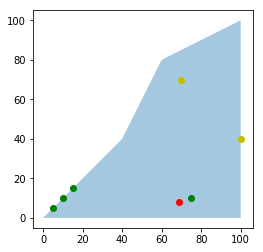

In [2883]:
draw_map(map_vertex_list, map_density_list, drone_list)

In [2884]:
#Start of algorithm
#SETUP:

In [2885]:
population = []

In [2886]:
#fills population with pop_size random but appropriate entries
def populate():
    global population, num_drones
    for _ in range(pop_size):
        temp_pop = []
        for _ in range(num_drones):
            add_to_pop = (np.random.randint(xmin, xmax), np.random.randint(ymin,ymax))
            while (not polygon_contains_point(add_to_pop)):
                add_to_pop = (np.random.randint(xmin, xmax), np.random.randint(ymin,ymax))
            temp_pop.append(add_to_pop)
            
        population.append(temp_pop)

In [2887]:
populate()

In [2888]:
#DRAW

In [2889]:
#append the fitness to every proposed map in population
    #fitness is defined as the number of users covered under a given map
    #TO DO: make sure drones dont count the same cluster more than once...
def fitness():
    global best_fitness, population
    adj_population = []
    index = -1
    for proposed_map in population:
        score = 0
        cluster_exclusion_list = []
        for drone in proposed_map:

            for (x, y, m) in map_density_list:
                dist = np.sqrt((x-drone[0])**2 + (y-drone[1])**2)
                #print(drone)
                if (dist <= circle_radius and (x, y, m) not in cluster_exclusion_list):
                    cluster_exclusion_list.append((x, y, m))
                    for _ in range(m):
                        adj_population.append(proposed_map)
                    score += m
        index += 1
        if (score >= best_fitness[0]):
            best_fitness = (score, index)
    return adj_population

In [2890]:
def draw(adj_population):
    global population
    population = []
    mutation_check = 0
    for n in range(pop_size):
        add_to_pop = []
        for m in range(num_drones):
            rand1 = np.random.randint(0, len(adj_population))
            rand2 = np.random.randint(0, len(adj_population))
            
            
            if (mutation_check == 1/mutation_rate):
                mut_rand = np.random.randint(0,2)
                if (mut_rand == 0):
                    add_to_pop.append((np.random.randint(xmin, xmax), get_y(adj_population[rand2][m])))
                else:
                    add_to_pop.append((get_x(adj_population[rand1][m]), np.random.randint(ymin, ymax)))
                mutation_check = 0
            else:
                add_to_pop.append((get_x(adj_population[rand1][m]), get_y(adj_population[rand2][m])))
        
        mutation_check += 1
        population.append(add_to_pop)

In [2891]:
fit = fitness()
it = 0
while(get_best_score(best_fitness) < optimal_fitness):
    draw(fit)
    print("Best score: " + str(get_best_score(best_fitness)) + " | Proposed Map: " + str(population[get_best_index(best_fitness)]))
    fit = fitness()
    it += 1
print("Best score: " + str(get_best_score(best_fitness)) + " | Proposed Map: " + str(population[get_best_index(best_fitness)]))
print("total iterations: " + str(it))

Best score: 41 | Proposed Map: [(31, 25), (69, 53), (58, 29), (67, 14)]
Best score: 41 | Proposed Map: [(92, 39), (77, 10), (78, 65), (67, 16)]
Best score: 41 | Proposed Map: [(67, 23), (78, 28), (75, 28), (71, 74)]
Best score: 41 | Proposed Map: [(39, 48), (72, 3), (99, 8), (65, 52)]
Best score: 41 | Proposed Map: [(92, 63), (91, 76), (73, 56), (69, 2)]
Best score: 41 | Proposed Map: [(50, 39), (77, 9), (74, 46), (68, 28)]
Best score: 41 | Proposed Map: [(14, 11), (78, 30), (91, 2), (68, 8)]
Best score: 41 | Proposed Map: [(74, 68), (66, 30), (74, 11), (68, 14)]
Best score: 41 | Proposed Map: [(50, 63), (11, 7), (67, 2), (83, 77)]
Best score: 41 | Proposed Map: [(72, 13), (77, 61), (98, 9), (72, 65)]
Best score: 41 | Proposed Map: [(74, 11), (70, 2), (74, 65), (72, 63)]
Best score: 50 | Proposed Map: [(73, 68), (74, 18), (93, 11), (75, 5)]
Best score: 50 | Proposed Map: [(74, 13), (62, 77), (74, 76), (72, 6)]
Best score: 50 | Proposed Map: [(80, 12), (98, 9), (66, 2), (86, 65)]
Best s

Best score: 51 | Proposed Map: [(94, 36), (72, 7), (74, 62), (7, 14)]


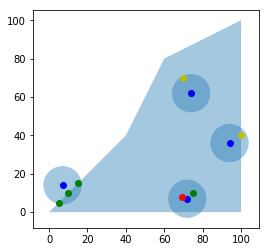

In [2892]:
print("Best score: " + str(get_best_score(best_fitness)) + " | Proposed Map: " + str(population[get_best_index(best_fitness)]))
#illustrate solution
drone_list = population[get_best_index(best_fitness)]
draw_map(map_vertex_list, map_density_list, drone_list)